Make sure to create a new conda environment using the environment.yml file
```
conda env create -f environment.yml
```

In [ ]:

import matplotlib.pyplot as plt
import torch
import utils
import tqdm
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.means import ConstantMean
import pandas as pd
from sklearn.model_selection import train_test_split
import tqdm
from gpytorch.kernels import ScaleKernel, RBFKernel, LinearKernel, InducingPointKernel


device = 'cpu'
dtype = torch.float64


In [2]:
import hysys_python.hysys_object_persistence as hop
import hysys_gsa_util as hgu
import numpy as np
import time as ti
from IPython.display import clear_output
%load_ext line_profiler


In [3]:
inputs = pd.read_csv('top_inputs.csv')
outputs = pd.read_csv('top_outputs.csv')
X = torch.tensor(inputs.values)
y = torch.tensor(outputs.values)

In [ ]:
filepath = r"C:\Data generation\Dimethyl ether - Aspen HYSYS\i-dme-complete-gsa-equil.hsc"  # path to the hysys file
file = filepath + r"\i-dme-complete-gsa-equil.hsc"

# Creating and connecting to the hysys flowsheet and solve
try:
    sim = hop.hysys_connection(file, active=1)
except:
    sim = hop.hysys_connection(file, active=0)

fsheet = sim.Flowsheet
solver = sim.Solver

In [ ]:
## BOUNDS
# electricity prices - 2018-2023 https://tradingeconomics.com/united-kingdom/electricity-price
elec_nom = 89.2 # GBP/MWh - 02 Jan 2024
elec_nom *= 0.804354 # USD/MWh
elec_nom /= 1000 # USD/kWh

# For the nominal/range of the MeOH reactor size from van Dal 2013
ref_co2_flow = 88e3 # kg/h CO2
co2_flow = 28333.3620500565 # kg/h in simulation
co2_ratio = co2_flow/ref_co2_flow
ref_cat_mass = 44500 # kg catalyst
cat_mass = ref_cat_mass*co2_ratio # kg catalyst in simulation
void = 0.5
density = 1775
meoh_nominal_vol = cat_mass * (1/density) * (1/(1-void)) # m3

bounds = [[2.4, 3.6],       # h2 ratio - +/-20% of stoich
        [5000, 10000],    # meoh pressure - van-dal2013
        [210, 270],       # meoh feed temp - van-dal2013
        [0, 1],           # adiabatic/isothermal meoh
        [0.95, 0.991],      # recycle ratio
        [0.8*meoh_nominal_vol, 1.2*meoh_nominal_vol], # meoh reactor volume - van-dal2013 +/- 20%
        #[250, 300],       # dme feed temperature - peinado2020    
        #[1000, 2000],     # dme reaction pressure - peinado2020
        #[0,1],            # feed vapour fraction meoh column
        #[0,1],            # feed vapour fraction dme-meoh column
        #[57*0.8, 57*1.2], # trays col 1 +/- 20% of nominal
        #[17*0.8, 17*1.2], # trays col 2 +/- 20% of nominal
        #[44/57*0.8, 44/57*1.2], # relative feed location col 1 +/- 20% of nominal
        #[10/17*0.8, 10/17*1.2]  # relative feed location col 2 +/- 20% of nominal
        ]

In [6]:
# function to pass the gsa sample points to the flowsheet, solve it and then calculate the outputs
def solve_flowsheet(fsheet, solver, inputs):
    sim.Visible = False # hiding the simulation improves solve time
    # Running the flowsheet
    try:
        out = hgu.solve_calc_flowsheet(fsheet, solver, inputs)
    except:
        out = [None, None, None, None, None, None]


    clear_output(wait=True)

    return out

In [7]:
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from gpytorch.kernels import MaternKernel, RBFKernel
from botorch.models.transforms import Standardize



def initialize_model(X, y, GP=None, state_dict=None, *GP_args, **GP_kwargs):
    """
    Create GP model and fit it. The function also accepts
    state_dict which is used as an initialization for the GP model.
    
    Parameters
    ----------
    X : torch.tensor, shape=(n_samples, dim)
        Input values
        
    y : torch.tensor, shape=(n_samples,)
        Output values
        
    GP : botorch.models.Model
        GP model class
        
    state_dict : dict
        GP model state dict
        
    Returns
    -------
    mll : gpytorch.mlls.MarginalLoglikelihood
        Marginal loglikelihood
    
    gp : 
    """

    covar_module = MaternKernel(nu=2.5)


    if GP is None:
        GP = SingleTaskGP
        
    model = GP(X, y,  outcome_transform=Standardize(1), covar_module = covar_module, *GP_args, **GP_kwargs).to(X)

    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # load state dict if it is passed
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return mll, model

In [ ]:
from botorch.optim import optimize_acqf

def bo_step(X, y, objective, bounds, GP=None, acquisition=None, q=1, state_dict=None, plot=False):
    # Create GP model if not provided
    if y is not None:
        mll, gp = initialize_model(X, y, GP=GP, state_dict=state_dict)
        fit_gpytorch_model(mll)
    
    # Create acquisition function
    acquisition = acquisition(gp)
    
    # Optimize acquisition function if y is not None
    if y is not None:
        candidate = optimize_acqf(
            acquisition, bounds=bounds, q=q, num_restarts=50, raw_samples=1024,
        )

        # Check if objective is not None before updating y
        y_new = objective(candidate[0].squeeze())
        print('y_new=', y_new)
        if y_new is not None:
            y = torch.cat([y, y_new])
            X = torch.cat([X, candidate[0]])
        else: 
            # Repeat until y_random is not None
            while True:
                X_random = torch.rand(6)
                y_rand = objective(X_random)
                if y_rand is not None:
                    break
            X = torch.cat([X, X_random.unsqueeze(0)])
            y = torch.cat([y, y_rand])

    if plot:
        utils.plot_acquisition(acquisition, X, y, candidate)
        
    return X, y, gp



In [9]:
from botorch.utils.transforms import normalize, unnormalize

def normalize_x(params, space):
    bounds = torch.tensor([var['domain'] for var in space]).to(params).t()
    params = normalize(params, bounds)
    return params

def unnormalize_x(params, space):
    bounds = torch.tensor([var['domain'] for var in space]).to(params).t()
    params = unnormalize(params, bounds)
    return params

def wrap_X(X, space):

    def _wrap_row(row):
        wrapped_row = {}
        for i, x in enumerate(row):
            wrapped_row[space[i]['name']] = x.item()
        
            if space[i]['type'] == 'discrete':
                wrapped_row[space[i]['name']] = int(np.round(x.item()))
        return wrapped_row
    
    wrapped_X = []
    for i in range(X.shape[0]):
        wrapped_X.append(_wrap_row(X[i]))
        
    return wrapped_X


def unwrap_X(parameters, space):

    X = torch.zeros(len(parameters), len(space),
                    dtype=torch.float64)
    for i, p in enumerate(parameters):
        x = [p[var['name']] for var in space]
        X[i] = torch.tensor(x, dtype=torch.float64)
        
    return X





In [ ]:
def superpro(p,space):
    
    #print(p)
    p = unnormalize_x(p, space)
    p = p.numpy()


    #p_all = [3, 7800, 210, 0, 0.99, meoh_nominal_vol, 275, 1500, 0.5, 0.5, 57, 17, 44/57, 10/17]

    p_all = [p[0], p[1], p[2], p[3], p[4], p[5], 275, 1500, 0.5, 0.5, 57, 17, 44/57, 10/17]

    try:
        out = solve_flowsheet(fsheet, solver, p_all)
        print(out)
    except:
        try: # try open hysys and solve flowsheet once more if crashes
            sim = hop.hysys_connection(file, active=0)
            fsheet = sim.Flowsheet
            solver = sim.Solver
            out = solve_flowsheet(fsheet, solver, p_all)
        except:
            # if still crashes, open file again but skip this point
            sim = hop.hysys_connection(file, active=0)
            fsheet = sim.Flowsheet
            solver = sim.Solver
            out = [None, None, None, None, None, None]

    if out[0] is None:
        return None
    else:
        return torch.tensor(out[0]).unsqueeze(-1).unsqueeze(-1).to(torch.float64) #datatype=torch.float64)

In [11]:
from botorch.utils.sampling import draw_sobol_samples

# Define the region
space = [
    {'name': 'h2_ratio', 'type': 'continuous', 'domain': (2.4, 3.6)},
    {'name': 'Pmeoh', 'type': 'continuous', 'domain': (5000, 10000)},
    {'name': 'Tmeoh', 'type': 'continuous', 'domain': (210, 270)},
    {'name': 'ad_is', 'type': 'continuous', 'domain': (0, 1)},
    {'name': 'recycle_ratio', 'type': 'continuous', 'domain': (0.95, 0.991)},
    {'name': 'Vtotal', 'type': 'continuous', 'domain': (0.8*meoh_nominal_vol, 1.2*meoh_nominal_vol)},
    #{'name': 'Tdme', 'type': 'continuous', 'domain': (250, 300)},
    #{'name': 'Pdme', 'type': 'continuous', 'domain': (1000, 2000)},
    #{'name': 'Xmeoh', 'type': 'continuous', 'domain': (0, 1)},
    #{'name': 'Xdme', 'type': 'continuous', 'domain': (0, 1)},
    #{'name': 'trays1', 'type': 'continuous', 'domain': (57*0.8, 57*1.2)},
    #{'name': 'trays2', 'type': 'continuous', 'domain': (17*0.8, 17*1.2)},
    #{'name': 'feed_loc1', 'type': 'continuous', 'domain': (44/57*0.8, 44/57*1.2)}, 
    #{'name': 'feed_loc2', 'type': 'continuous', 'domain': (10/17*0.8, 10/17*1.2)}, 
]




bounds_01 = torch.zeros(2, len(space), dtype=torch.float64)
bounds_01[1] = 1

init_X = draw_sobol_samples(bounds_01, 6, 1).squeeze()

init_y = []
valid_init_X = []


while len(init_y) < 5:
    for i in range(len(init_X)):
        result = superpro(init_X[i], space)
        if result is not None:
            init_y.append(result)
            valid_init_X.append(init_X[i])
    
    # If len(init_y) is still less than 5, generate additional Sobol samples
    if len(init_y) < 5:
        additional_samples = draw_sobol_samples(bounds_01, 5 - len(init_y), 1).squeeze()
        init_X = torch.cat([init_X, additional_samples])

# Now init_X, init_y, and valid_init_X correspond to each other


Set inputs in 0.15s
Initial solve up to Reactor100 in 0.21s
Solved Reactor100 in 0.17s
Solved MIX-101_meoh_rcy in 2.46s
Solved K-103 in 0.11s
Solved Vessel 101 in 0.12s
Solved Twp101 in 0.34s
Solved V-100 in 0.20s
Solved CRV-100 in 0.15s
Solved Twb102 in 0.33s
Solved MIX-100_met_rcy in 0.34s
*** COMPLETE ***
Solved flowsheet in 4.48s

Sized DME reactor in 1.27s


In [ ]:
init_y2= torch.tensor(init_y)
init_y2= init_y2.reshape(-1,1)

tensor([[3.0650],
        [3.7010],
        [3.3529],
        [3.4775],
        [3.5149],
        [3.2769]], dtype=torch.float64)


In [ ]:

init_X2 = torch.stack(valid_init_X)
init_X2 = torch.cat([normalize_x(X, space), init_X2])
init_y2 = torch.cat([y, init_y2])

tensor([[0.8811, 0.8725, 0.7012, 0.2324, 0.9587, 0.7053],
        [0.8811, 0.8725, 0.7012, 0.2324, 0.9587, 0.0549],
        [0.8811, 0.8725, 0.7012, 0.2324, 0.9587, 0.0549],
        [0.8811, 0.8725, 0.7012, 0.2324, 0.9587, 0.0549],
        [0.8811, 0.8725, 0.7012, 0.2324, 0.9587, 0.0549],
        [0.8811, 0.8725, 0.7012, 0.2324, 0.9587, 0.0549],
        [0.8811, 0.8725, 0.7012, 0.2324, 0.9587, 0.0549],
        [0.8811, 0.8725, 0.7012, 0.2324, 0.9587, 0.0549],
        [0.8811, 0.8725, 0.7012, 0.2324, 0.9587, 0.0549],
        [0.8811, 0.8725, 0.7012, 0.2324, 0.9587, 0.0549],
        [0.0829, 0.7196, 0.7413, 0.9400, 0.6263, 0.9775],
        [0.9401, 0.4496, 0.1434, 0.4228, 0.4940, 0.3626],
        [0.5960, 0.9245, 0.8131, 0.6246, 0.0887, 0.1323],
        [0.4885, 0.1543, 0.2865, 0.0136, 0.7836, 0.5282],
        [0.3622, 0.8640, 0.0878, 0.1860, 0.8957, 0.7590],
        [0.7233, 0.0860, 0.5587, 0.6993, 0.2320, 0.3931]], dtype=torch.float64)
tensor([[3.9360],
        [3.9315],
        [3.930

In [ ]:
def get_best_params(params, scores, space):
    bounds = torch.tensor([var['domain'] for var in space]).to(params).t()
    params = unnormalize(params, bounds)
    
    best_idx = np.argmax(scores.cpu().numpy())
    
    return wrap_X(params[[best_idx]], space)[0]

In [ ]:
from botorch.acquisition import (ExpectedImprovement, PosteriorMean,
                                 ProbabilityOfImprovement,
                                 UpperConfidenceBound, qKnowledgeGradient)
from botorch.acquisition.max_value_entropy_search import qMaxValueEntropy
from botorch.sampling import SobolQMCNormalSampler
from botorch.acquisition.max_value_entropy_search import qMaxValueEntropy

cum_best_df = pd.DataFrame()
best_params_df = pd.DataFrame()



start_time = time.time()

for i in range(0, 100,10) :

    print('Seed:', i, 'out of 100')

    torch.manual_seed(i)



    params = init_X2 

    scores = init_y2

    state_dict = None

    budget = 116

    objective = lambda x: superpro(x, space)

    # Initialize the counter for consecutive iterations without improvement
    no_improvement_count = 0
    consecutive_iterations_threshold = 20  # Threshold for consecutive iterations without improvement

    best_score = float('-inf')  # Initialize the best score to a very low number

    with tqdm.tqdm(total=budget) as bar:
        while len(scores) < budget:
            n_samples = len(scores)
        
            # Assuming the rest of your optimization code goes here and updates `scores`
            GP = SingleTaskGP
        

            acquisition = lambda gp: UpperConfidenceBound(gp, beta=15, maximize=True)
        

            params, scores, gp = bo_step(params, scores, objective, bounds_01,
                                     GP=GP, acquisition=acquisition, 
                                     )
            
  
            current_best_score = scores.max().item()  # Get the current best score
        
            # Check if there is an improvement
            if current_best_score > best_score:
                best_score = current_best_score  # Update the best score
                no_improvement_count = 0  # Reset the counter since there was an improvement
            else:
                no_improvement_count += 1  # Increment the counter
        
            # Terminate if the number of consecutive iterations without improvement
            # reaches the threshold
            if no_improvement_count >= consecutive_iterations_threshold:
                print("Termination criterion met: No improvement for 20 consecutive iterations.")
                break  # Terminate the loop
        
            bar.update(len(scores) - n_samples)


        cum_best = np.maximum.accumulate(scores.cpu().numpy())

        # Create a temporary DataFrame from `cum_best` and reindex `cum_best_df` to ensure it's long enough
        temp_df = pd.DataFrame({f'{i}': cum_best.squeeze()})
        cum_best_df = cum_best_df.reindex(index=range(max(len(cum_best_df), len(temp_df)))).assign(**temp_df)
        best_param = get_best_params(params, scores, space)
        best_param_values = list(best_param.values())
        best_params_df[f'{i}'] = pd.Series(best_param_values)
 

 28%|██▊       | 33/116 [17:03<42:54, 31.01s/it]

y_new= tensor([[3.9150]], dtype=torch.float64)
Termination criterion met: No improvement for 20 consecutive iterations.
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.949479893592791
3.949479893592791
3.949479893592791
3.949479893592791
3.949479893592791
3.949479893592791
3.949479893592791
3.949479893592791
3.949479893592791
3.9791824611166673
3.9791824611166673
3.9791824611166673
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247


Execution time: 1025.50 seconds


h2_ratio: 3.5999999046325684

Pmeoh: 10000.0

Tmeoh: 270.0

ad_is: 0.44599704382978

recycle_ratio: 0.9909999966621399

Vtotal: 15.854133109053578

Optimum 3.983201141145247


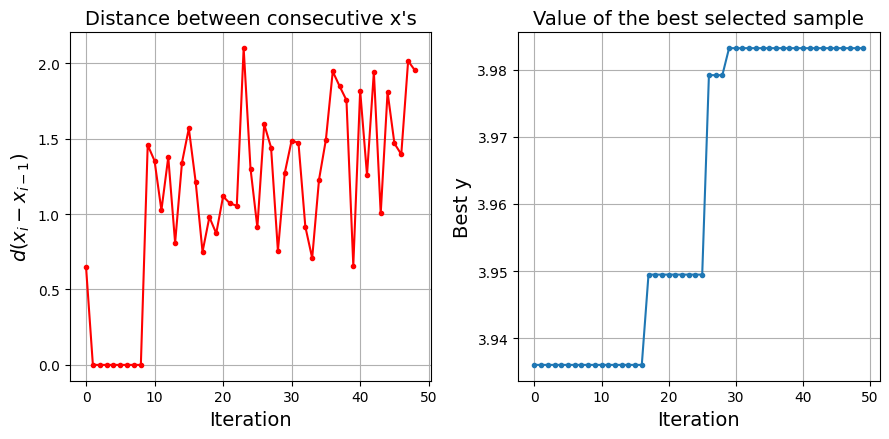

In [ ]:
#=============================================================RESULTS==============================================================

for key, value in best_param.items():
        print(f'{key}: {value}\n')

print('Optimum', scores.max().item())

utils.plot_convergence(params, scores, maximize=True)

In [ ]:

cum_best = np.maximum.accumulate(scores.cpu().numpy())

3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.936033638
3.949479893592791
3.949479893592791
3.949479893592791
3.949479893592791
3.949479893592791
3.949479893592791
3.949479893592791
3.949479893592791
3.949479893592791
3.9791824611166673
3.9791824611166673
3.9791824611166673
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
3.983201141145247
